In [ ]:
# 폰트 경로 찾기
import matplotlib.font_manager as fm

font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')
font_list[:]

In [1]:
import pandas as pd
import re

from matplotlib import rc
import matplotlib.font_manager as fm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns  # 다양한 색상 팔레트를 위해 추가

# 디렉토리 및 파일 이름에 맞추어 변경
font_location = 'C:\\Windows\\Fonts\\malgun.ttf'

font_name = fm.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False

# 원본 csv 전처리

In [2]:
# 데이터 초기 필터링
def filter_csv(path):
   data = pd.read_csv(path)

   # 행정동 코드
   code_df =pd.read_csv(r'C:\Users\Anichan\Documents\공부자료\24.03 광진구청 공모전\code\data\행정동 단위 서울 생활인구(내국인)\행정동코드_매핑정보.csv', encoding = 'cp949')

   # 광진구 행정동 코드
   code = list(code_df['행정동코드'])
   code_inplace = list(code_df['행정동명'])
   code_dict = {code[i]: code_inplace[i] for i in range(len(code))}

   # 광진구 행정동만 남김
   data = data[data['시간대구분'].isin(code)]

   data = data[data.columns[:-1]]
   data.reset_index(inplace = True)

   data = data[list(data.columns[:6]) + list(data.columns[19:21])]
   data.columns = ['기준일ID', '시간대구분', '행정동코드', '총생활인구수', '남자0세부터9세생활인구수', '남자10세부터14세생활인구수'
                   , '여자0세부터9세생활인구수', '여자10세부터14세생활인구수']

   # 행정동 이름 붙이기
   data['행정동'] = data['행정동코드'].apply(lambda x: code_dict[x])

   # 기준일ID datetime으로 변환하고 평일/휴일 구분
   data['기준일ID'] = data['기준일ID'].apply(lambda x: str(x))
   data['기준일ID'] = data['기준일ID'].apply(lambda x : x[0:4]+"-"+x[4:6]+"-"+x[6:])
   data['기준일ID'] = pd.to_datetime(data['기준일ID'])

   data['요일index'] = data['기준일ID'].dt.weekday
   # 0~6번 인덱스 위치에 각 한글 요일 이름이 담긴 리스트
   weekday_list = ['월', '화', '수', '목', '금', '토', '일']

   # apply 함수로 숫자 -> 요일 이름으로 변환
   data['요일'] = data['요일index'].apply(lambda x : weekday_list[x])
   data['평일/휴일'] = data['요일'].apply(lambda x : '휴일' if x == '토' or x == "일" else "평일")
   data = data.drop('요일index', axis = 1)
   data = data[ [data.columns[0]] + list(data.columns[-3:]) + list(data.columns[1:-3])]

   # 각 나이대 별 총 생활인구수 구하기
   # 연령대 목록
   age_groups = [
      "0세부터9세", "10세부터14세"
   ]

   # 총 생활인구수 컬럼 생성
   for age in age_groups:
      male_col = f'남자{age}생활인구수'
      female_col = f'여자{age}생활인구수'
      total_col = f'총{age}생활인구수'
      
      if male_col in data.columns and female_col in data.columns:
         data[total_col] = data[male_col] + data[female_col]

   return data


In [ ]:
for year in [202410,202411,202412,202501,202502]:
    path = f"./data/행정동 단위 서울 생활인구(내국인)/LOCAL_PEOPLE_DONG_{year}/LOCAL_PEOPLE_DONG_{year}.csv"
    
    data = filter_csv(path)
    data = data.drop(columns=['행정동코드'])
    data = data[['행정동','시간대구분', '평일/휴일'] + list(data.columns[6:])]
    data = data.groupby(['행정동', '평일/휴일','시간대구분']).mean()
    data.reset_index(inplace = True)

    # 평일 데이터만 필터링
    df_weekday = data[data['평일/휴일'] == '평일'].copy()

    # 활동/비활동 시간대 정의
    inactive_hours = list(range(19, 25)) + list(range(0, 8))  # 19-24, 0-7
    active_hours = list(range(8, 19))  # 8-18

    # 비활동 시간 평균 계산
    df_inactive = df_weekday[df_weekday['시간대구분'].isin(inactive_hours)].groupby('행정동')['총0세부터9세생활인구수'].mean().reset_index()
    df_inactive.rename(columns={'총0세부터9세생활인구수': '비활동시간_평균'}, inplace=True)

    # 활동 시간 평균 계산
    df_active = df_weekday[df_weekday['시간대구분'].isin(active_hours)].groupby('행정동')['총0세부터9세생활인구수'].mean().reset_index()
    df_active.rename(columns={'총0세부터9세생활인구수': '활동시간_평균'}, inplace=True)

    # 두 개의 데이터프레임 병합
    df_compare = pd.merge(df_inactive, df_active, on='행정동', how='outer')

    df_compare.to_csv(f'{year}_서울 생활인구_평일.csv', encoding = 'cp949', index = False)

In [ ]:
for year in [202410,202411,202412,202501,202502]:
    path = f"./data/행정동 단위 서울 생활인구(내국인)/LOCAL_PEOPLE_DONG_{year}/LOCAL_PEOPLE_DONG_{year}.csv"
    
    data = filter_csv(path)
    data = data.drop(columns=['행정동코드'])
    data = data[['행정동','시간대구분', '평일/휴일'] + list(data.columns[6:])]
    data = data.groupby(['행정동', '평일/휴일','시간대구분']).mean()
    data.reset_index(inplace = True)

    # 평일 데이터만 필터링
    df_weekday = data[data['평일/휴일'] == '휴일'].copy()

    # 활동/비활동 시간대 정의
    inactive_hours = list(range(19, 25)) + list(range(0, 8))  # 19-24, 0-7
    active_hours = list(range(8, 19))  # 8-18

    # 비활동 시간 평균 계산
    df_inactive = df_weekday[df_weekday['시간대구분'].isin(inactive_hours)].groupby('행정동')['총0세부터9세생활인구수'].mean().reset_index()
    df_inactive.rename(columns={'총0세부터9세생활인구수': '비활동시간_평균'}, inplace=True)

    # 활동 시간 평균 계산
    df_active = df_weekday[df_weekday['시간대구분'].isin(active_hours)].groupby('행정동')['총0세부터9세생활인구수'].mean().reset_index()
    df_active.rename(columns={'총0세부터9세생활인구수': '활동시간_평균'}, inplace=True)

    # 두 개의 데이터프레임 병합
    df_compare = pd.merge(df_inactive, df_active, on='행정동', how='outer')

    df_compare.to_csv(f'{year}_서울 생활인구_휴일.csv', encoding = 'cp949', index = False)

In [ ]:
import pandas as pd
import glob

# 모든 CSV 파일 경로 가져오기
file_paths = glob.glob('./data/행정동 단위 서울 생활인구(내국인)/*_서울 생활인구_휴일.csv')

# 각 CSV 파일 읽고 리스트에 저장
df_list = [pd.read_csv(file, encoding='cp949') for file in file_paths]

# 모든 데이터를 하나의 DataFrame으로 연결
df_all = pd.concat(df_list, ignore_index=True)

# 행정동별 평균 계산
df_mean = df_all.groupby('행정동')[['비활동시간_평균', '활동시간_평균']].mean().reset_index()

# 결과 저장
df_mean.to_csv('서울_생활인구_휴일_전체평균.csv', encoding='cp949', index=False)


In [ ]:
import pandas as pd
import glob

# 모든 CSV 파일 경로 가져오기
file_paths = glob.glob('./data/행정동 단위 서울 생활인구(내국인)/*_서울 생활인구_평일.csv')

# 각 CSV 파일 읽고 리스트에 저장
df_list = [pd.read_csv(file, encoding='cp949') for file in file_paths]

# 모든 데이터를 하나의 DataFrame으로 연결
df_all = pd.concat(df_list, ignore_index=True)

# 행정동별 평균 계산
df_mean = df_all.groupby('행정동')[['비활동시간_평균', '활동시간_평균']].mean().reset_index()

# 결과 저장
df_mean.to_csv('서울_생활인구_평일_전체평균.csv', encoding='cp949', index=False)


# 시각화

In [ ]:
year = 202410
path = f'{year}_광진구 생활인구.csv'
data = pd.read_csv(path, encoding = 'cp949')

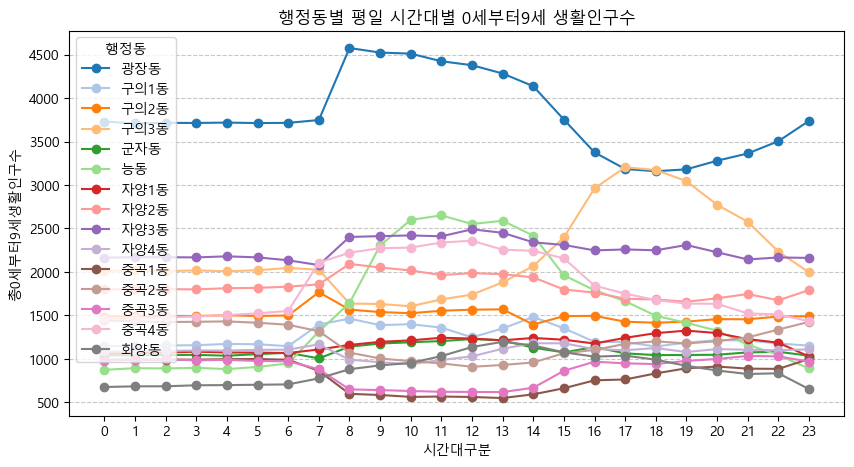

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # 다양한 색상 팔레트를 위해 추가

# 평일 데이터 필터링
filtered_df = data[data['평일/휴일'] == '평일']

# 시각화 설정
plt.figure(figsize=(10, 5))

# Seaborn 색상 팔레트 사용 (행정동 개수만큼 자동 배정)
colors = sns.color_palette("tab20", n_colors=len(filtered_df['행정동'].unique()))

# 각 행정동에 대해 라인 그래프 생성
for idx, dong in enumerate(filtered_df['행정동'].unique()):
    dong_df = filtered_df[filtered_df['행정동'] == dong]
    plt.plot(dong_df['시간대구분'], dong_df['총0세부터9세생활인구수'], marker='o', label=dong, color=colors[idx])

plt.xlabel('시간대구분')
plt.ylabel('총0세부터9세생활인구수')
plt.title('행정동별 평일 시간대별 0세부터9세 생활인구수')
plt.xticks(filtered_df['시간대구분'].unique())  # X축 값 설정
plt.legend(title='행정동')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 출력
plt.show()


## 평일

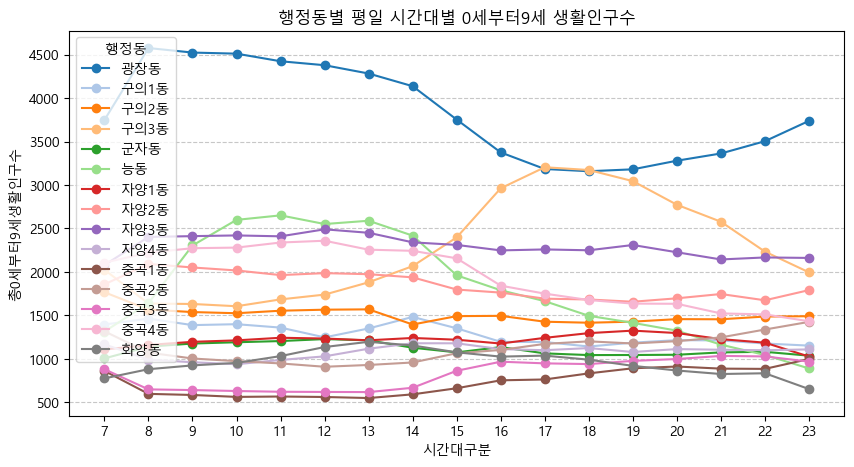

In [ ]:
# 평일 데이터 필터링
filtered_df = data[data['평일/휴일'] == '평일']

filtered_df = filtered_df[filtered_df['시간대구분']>6]

# 시각화 설정
plt.figure(figsize=(10, 5))

# Seaborn 색상 팔레트 사용 (행정동 개수만큼 자동 배정)
colors = sns.color_palette("tab20", n_colors=len(filtered_df['행정동'].unique()))

# 각 행정동에 대해 라인 그래프 생성
for idx, dong in enumerate(filtered_df['행정동'].unique()):
    dong_df = filtered_df[filtered_df['행정동'] == dong]
    plt.plot(dong_df['시간대구분'], dong_df['총0세부터9세생활인구수'], marker='o', label=dong, color=colors[idx])

plt.xlabel('시간대구분')
plt.ylabel('총0세부터9세생활인구수')
plt.title('행정동별 평일 시간대별 0세부터9세 생활인구수')
plt.xticks(filtered_df['시간대구분'].unique())  # X축 값 설정
plt.legend(title='행정동')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 출력
plt.show()


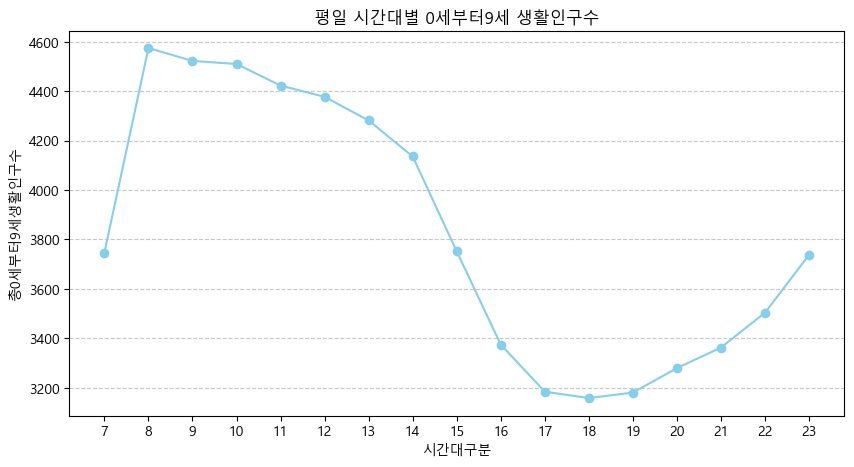

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# 광장동 & 평일 필터링
filtered_df = data[(data['행정동'] == '광장동') & (data['평일/휴일'] == '평일')]

filtered_df = filtered_df[filtered_df['시간대구분']>6]

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(filtered_df['시간대구분'], filtered_df['총0세부터9세생활인구수'], color='skyblue', marker='o')

plt.xlabel('시간대구분')
plt.ylabel('총0세부터9세생활인구수')
plt.title('평일 시간대별 0세부터9세 생활인구수')
plt.xticks(filtered_df['시간대구분'])  # X축 값 표시
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 출력
plt.show()


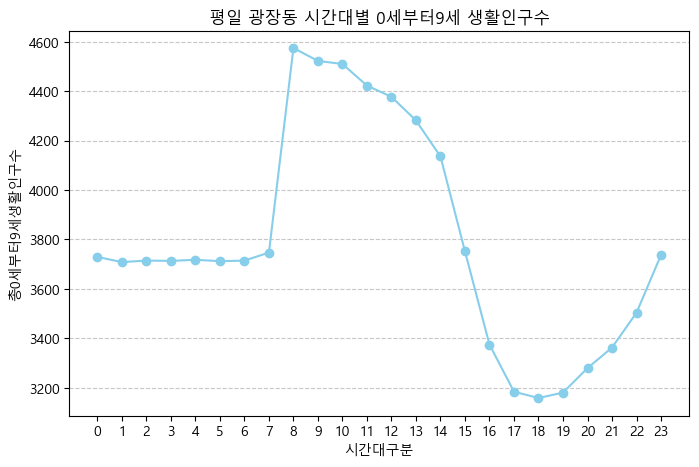

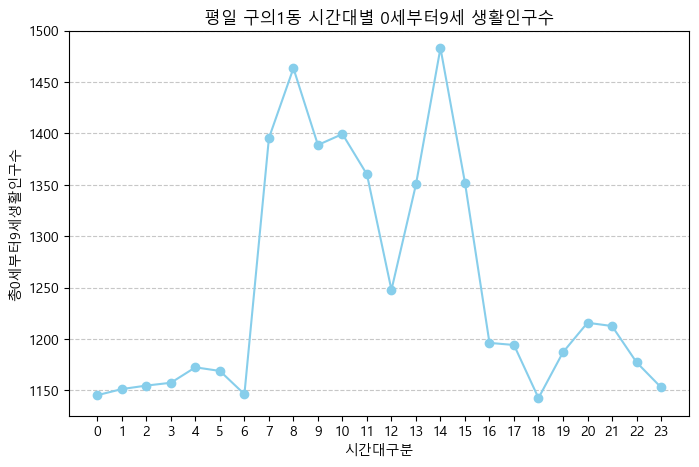

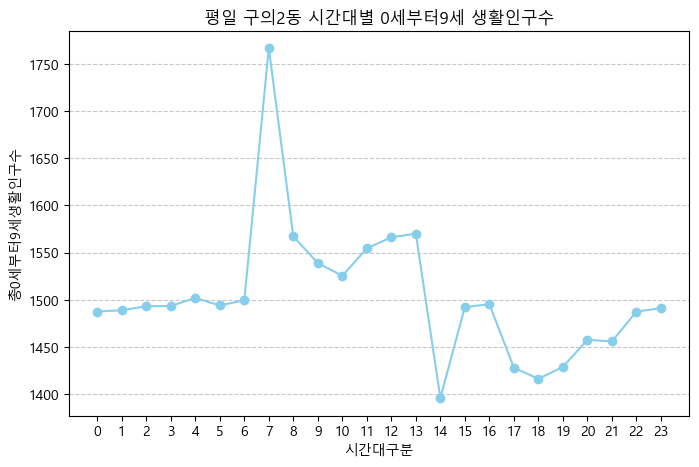

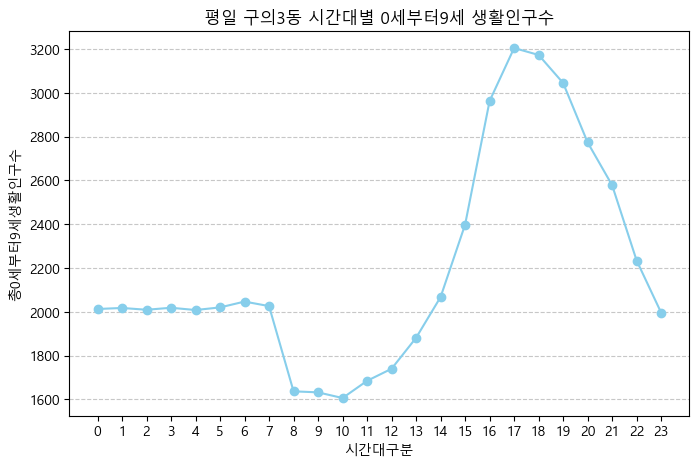

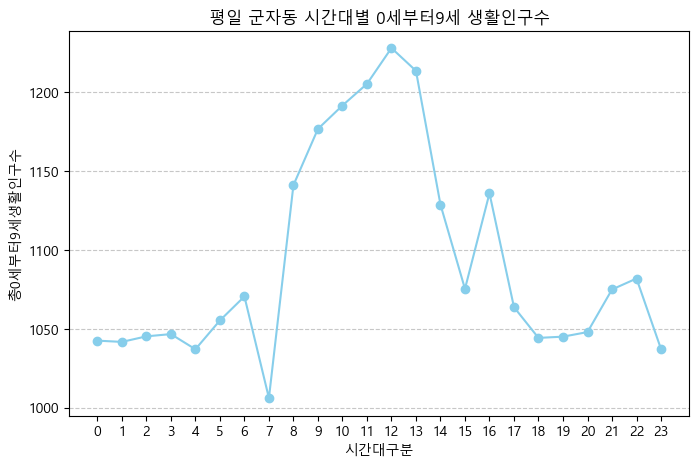

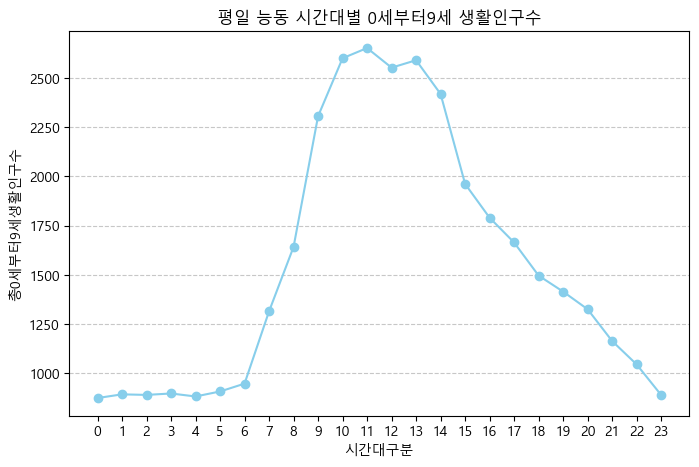

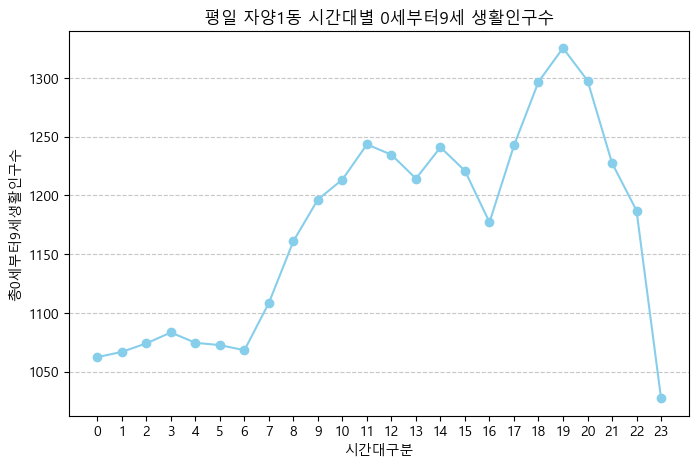

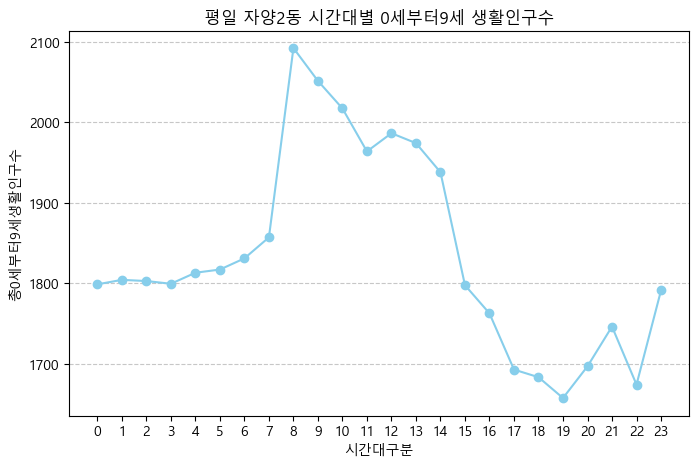

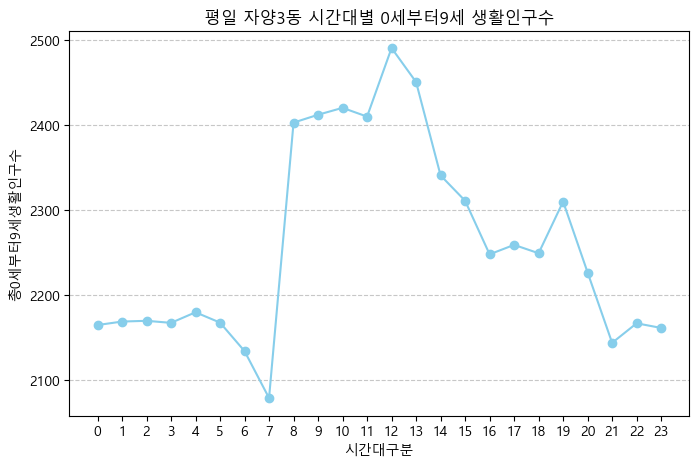

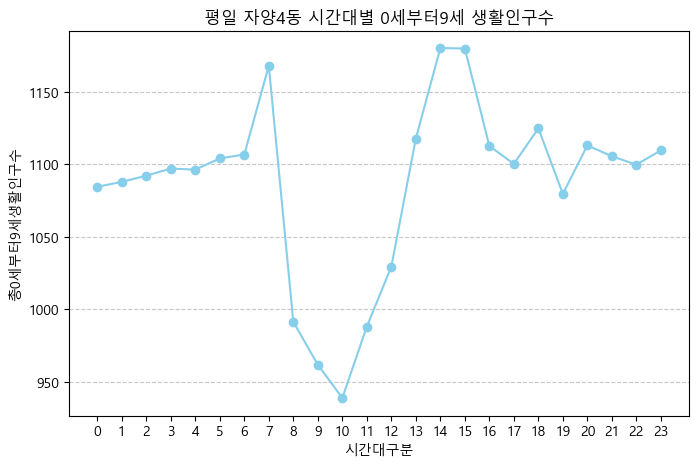

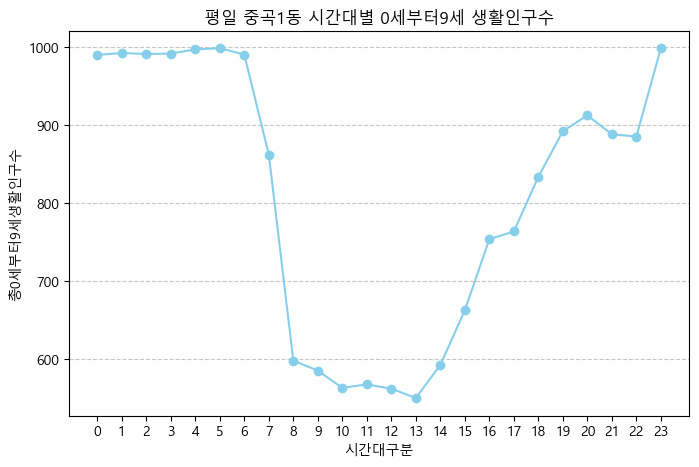

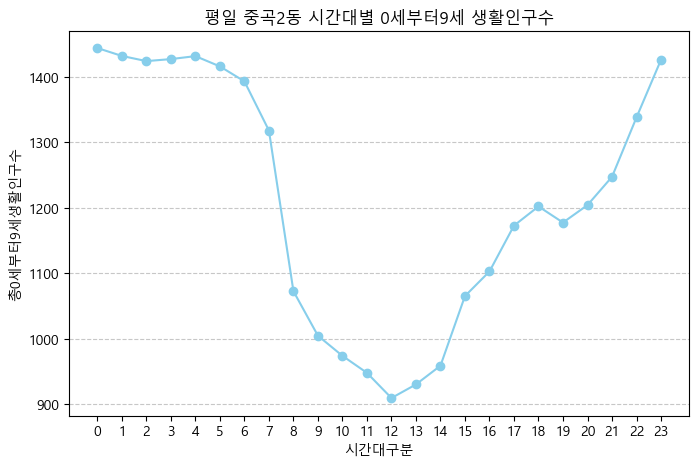

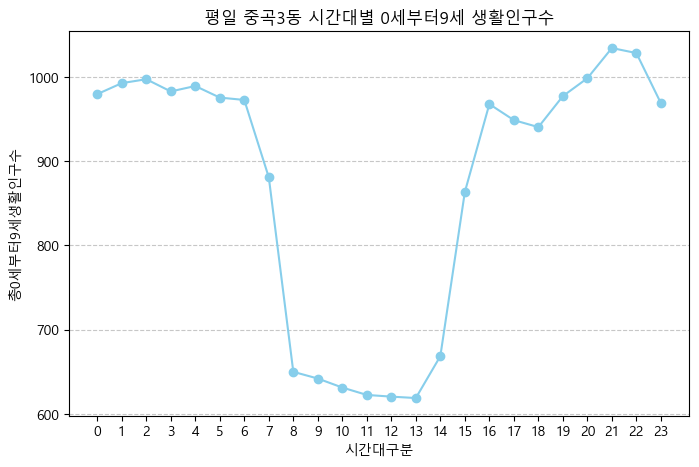

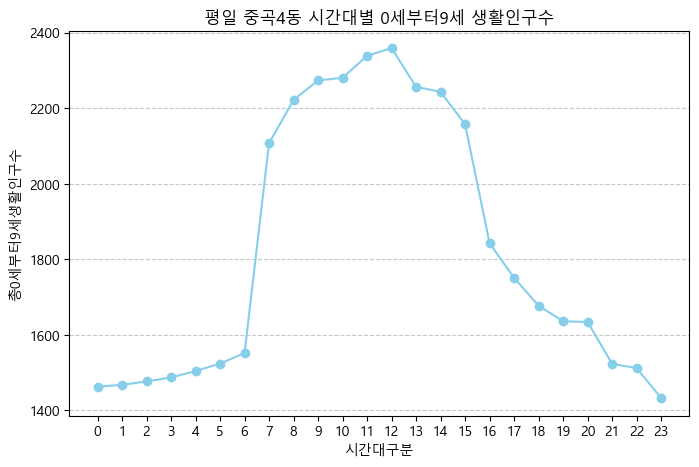

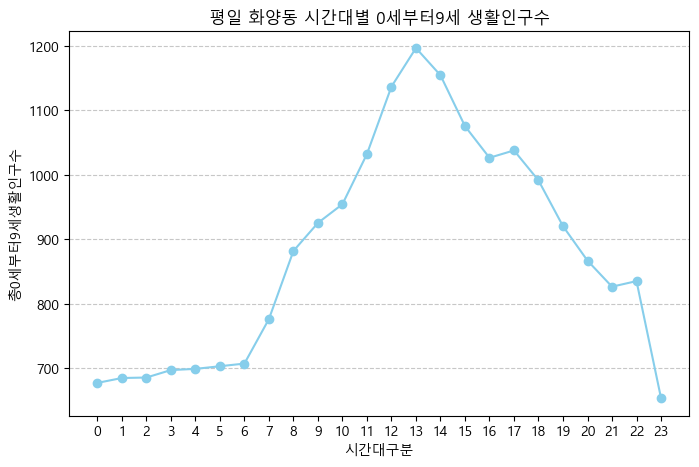

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# 광장동 & 평일 필터링
filtered_df = data[data['평일/휴일'] == '평일']

# filtered_df = filtered_df[filtered_df['시간대구분']>6]

# 시각화
for dong in filtered_df['행정동'].unique():
    df_selected = filtered_df[filtered_df['행정동'] == dong]
    plt.figure(figsize=(8, 5))
    plt.plot(df_selected['시간대구분'], df_selected['총0세부터9세생활인구수'], color='skyblue', marker='o')

    plt.xlabel('시간대구분')
    plt.ylabel('총0세부터9세생활인구수')
    plt.title(f'평일 {dong} 시간대별 0세부터9세 생활인구수')
    plt.xticks(df_selected['시간대구분'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()


## 주말 증감률

In [30]:
# 평일과 주말 데이터 분리
df_weekday = data[data['평일/휴일'] == '평일'].groupby(['행정동', '시간대구분'])['총0세부터9세생활인구수'].sum()
df_weekend = data[data['평일/휴일'] == '휴일'].groupby(['행정동', '시간대구분'])['총0세부터9세생활인구수'].sum()

# 증감률 계산
df_change = pd.DataFrame({'평일': df_weekday, '주말': df_weekend})
df_change['증감률(%)'] = ((df_change['주말'] - df_change['평일']) / df_change['평일']) * 100

# NaN 값(평일 데이터가 0인 경우) 처리
df_change = df_change.fillna(0).reset_index()

# 결과 출력
print(df_change)


     행정동  시간대구분           평일           주말     증감률(%)
0    광장동      0  3729.464204  3571.292938  -4.241126
1    광장동      1  3708.378635  3569.213987  -3.752709
2    광장동      2  3714.541130  3576.533925  -3.715323
3    광장동      3  3713.301848  3590.295762  -3.312580
4    광장동      4  3717.751835  3592.443337  -3.370545
..   ...    ...          ...          ...        ...
355  화양동     19   920.395543  1270.887563  38.080586
356  화양동     20   866.913526  1096.321450  26.462608
357  화양동     21   826.502348   957.388663  15.836170
358  화양동     22   835.144309   912.722263   9.289168
359  화양동     23   653.692165   693.209112   6.045192

[360 rows x 5 columns]


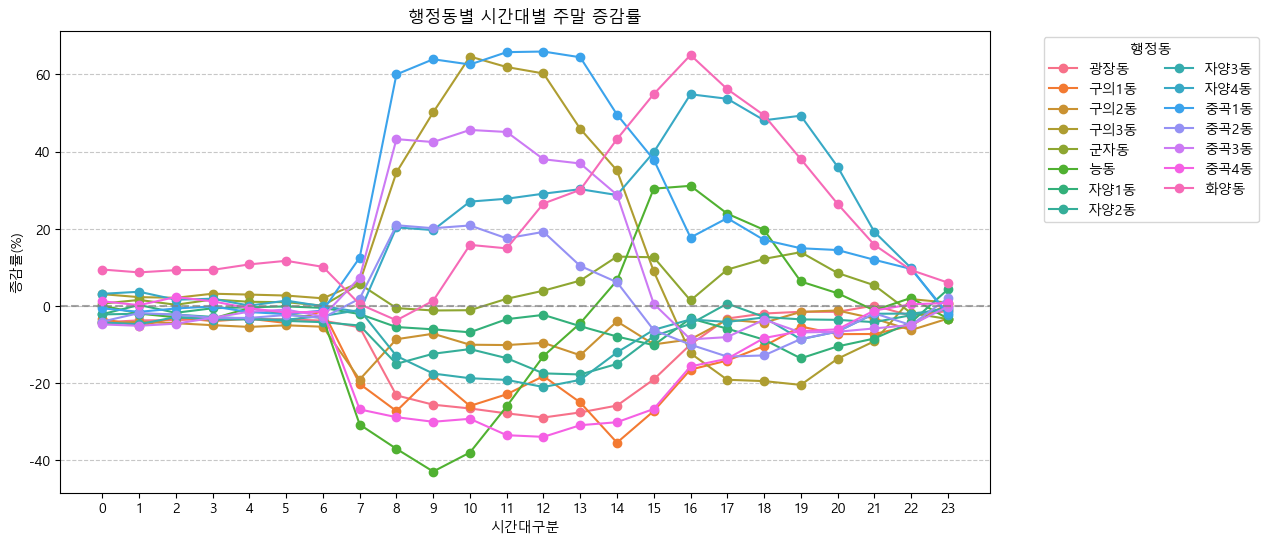

In [11]:
# 시각화 설정
plt.figure(figsize=(12, 6))

# 15개 이상의 컬러 사용
colors = sns.color_palette("husl", n_colors=len(df_change['행정동'].unique()))

# 각 행정동에 대해 라인 그래프 생성
for idx, dong in enumerate(df_change['행정동'].unique()):
    dong_df = df_change[df_change['행정동'] == dong]
    plt.plot(dong_df['시간대구분'], dong_df['증감률(%)'], marker='o', label=dong, color=colors[idx])

plt.xlabel('시간대구분')
plt.ylabel('증감률(%)')
plt.title('행정동별 시간대별 주말 증감률')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)  # 기준선 추가
plt.xticks(df_change['시간대구분'].unique())  # X축 값 설정
plt.legend(title='행정동', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # 범례를 그래프 오른쪽으로 배치
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 출력
plt.show()


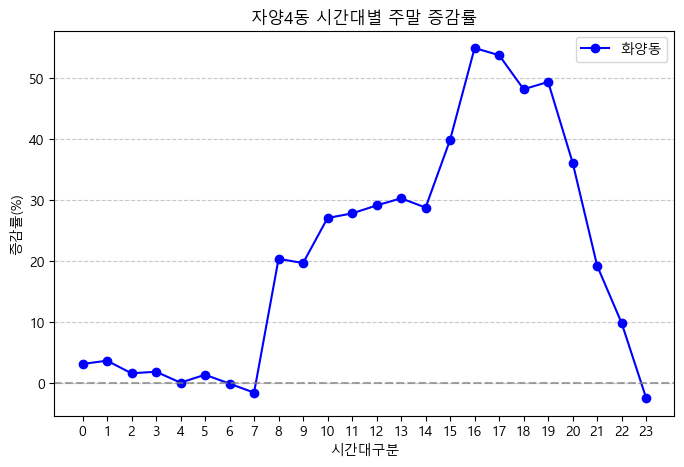

In [72]:
# 특정 행정동만 보기
dong = '자양4동'
df_hwayang = df_change[df_change['행정동'] == dong]

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(df_hwayang['시간대구분'], df_hwayang['증감률(%)'], marker='o', linestyle='-', color='b', label='화양동')

plt.xlabel('시간대구분')
plt.ylabel('증감률(%)')
plt.title(f'{dong} 시간대별 주말 증감률')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)  # 기준선 추가
plt.xticks(df_hwayang['시간대구분'].unique())  # X축 값 설정
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 출력
plt.show()


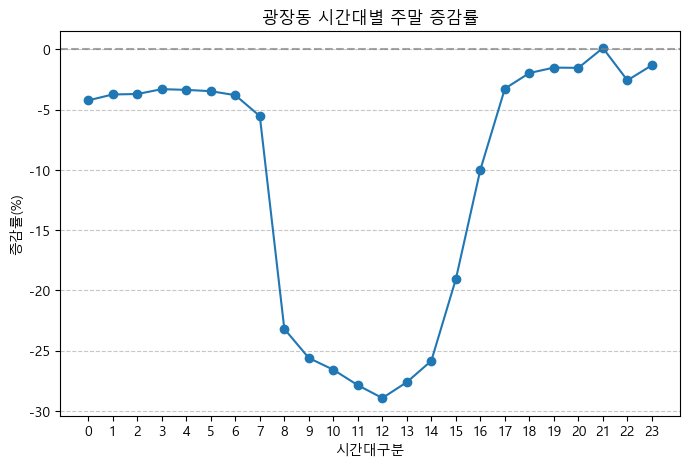

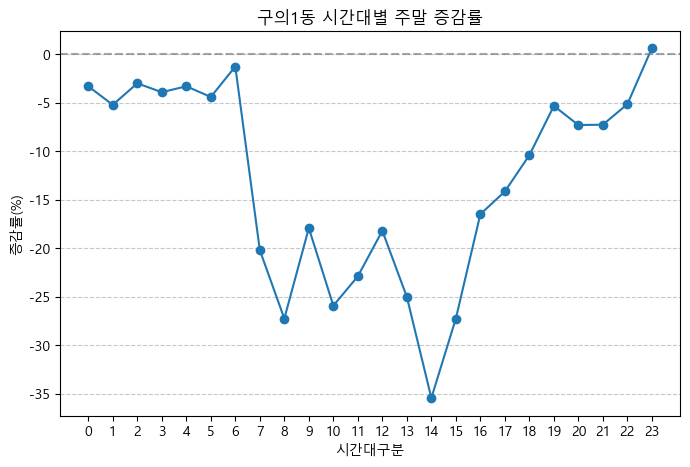

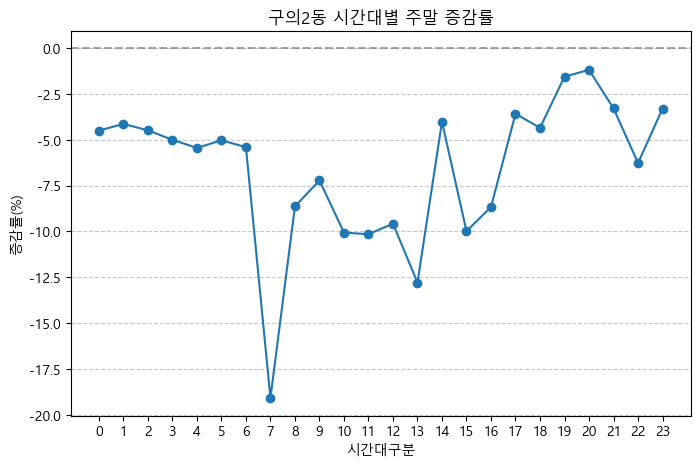

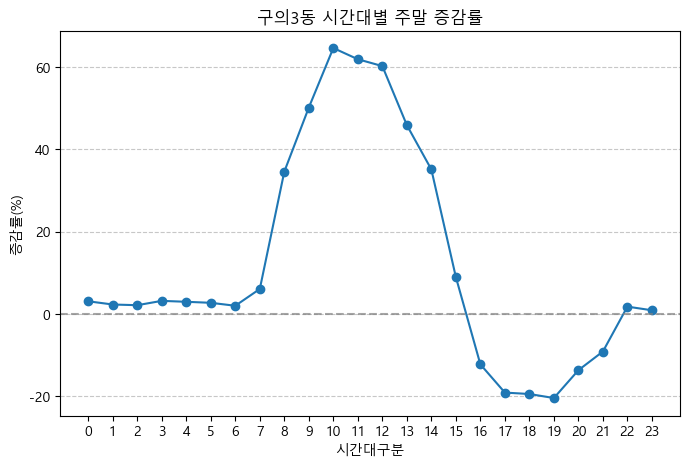

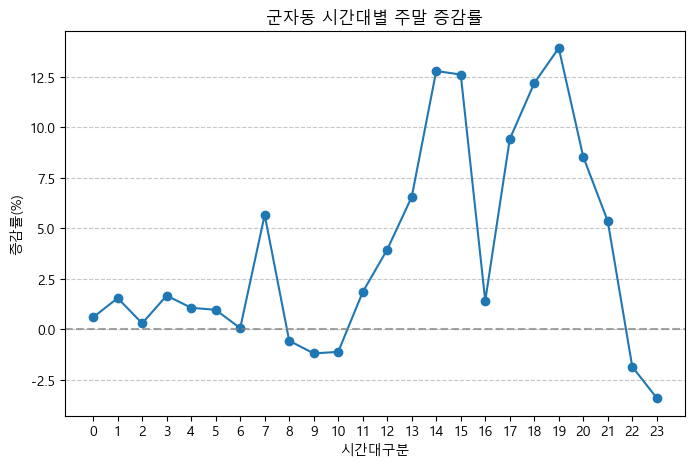

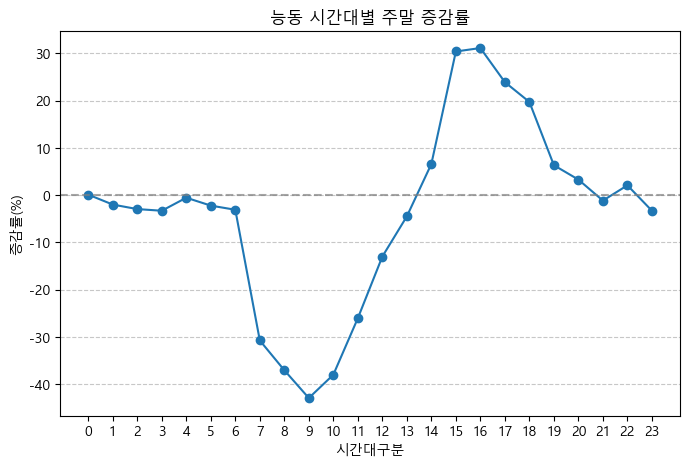

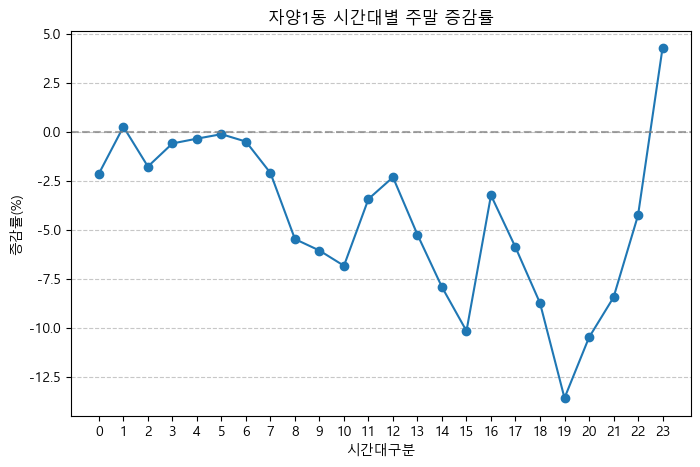

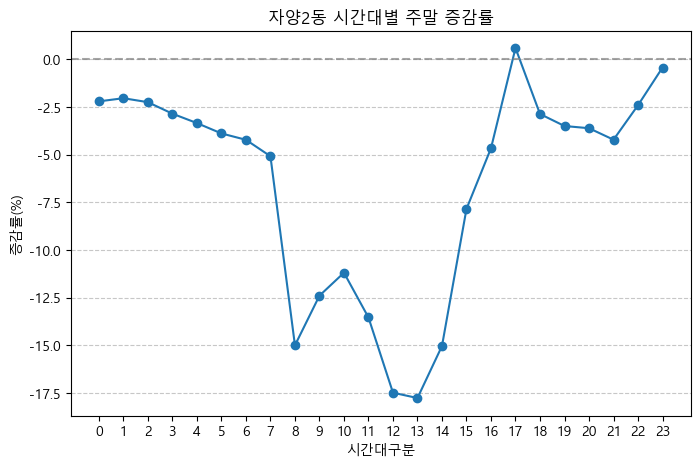

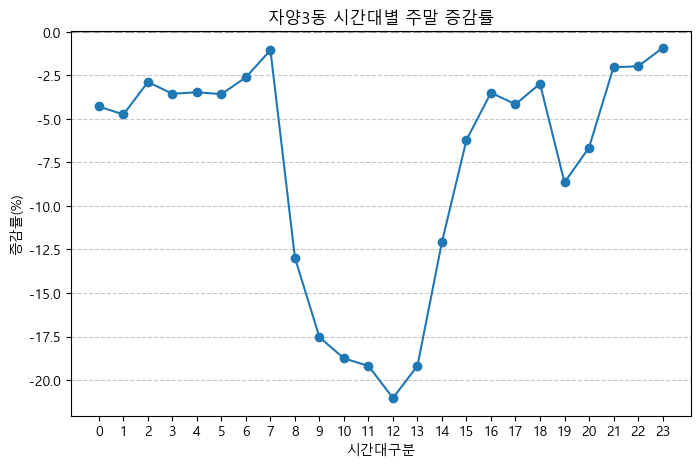

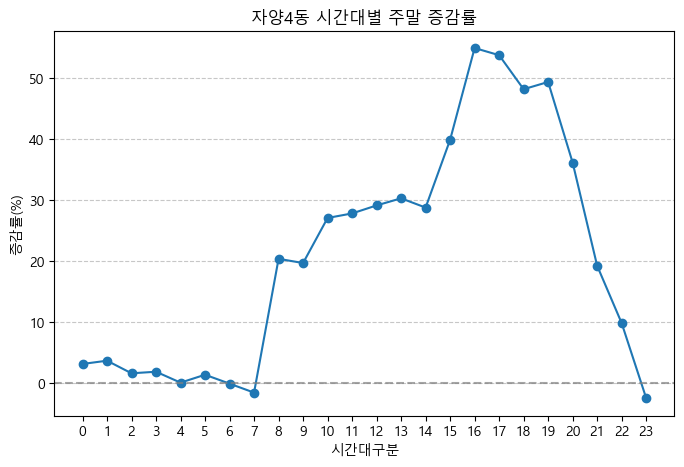

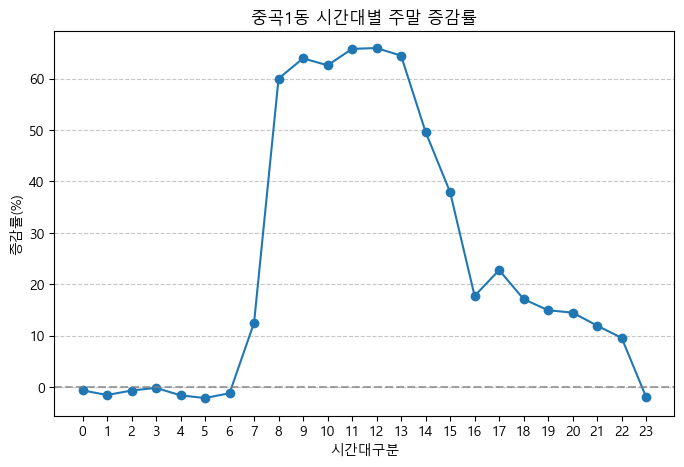

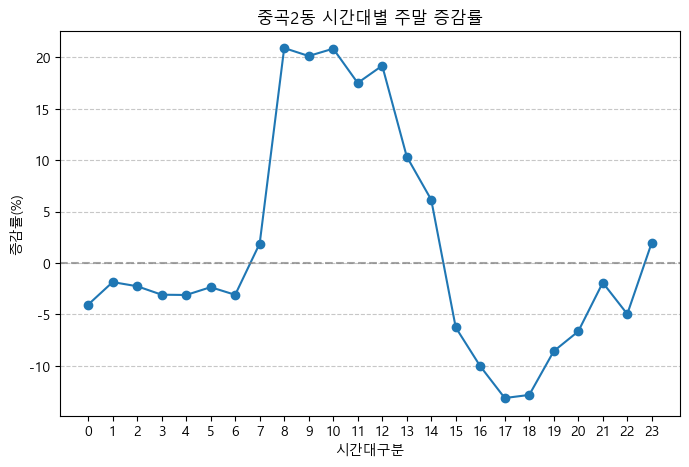

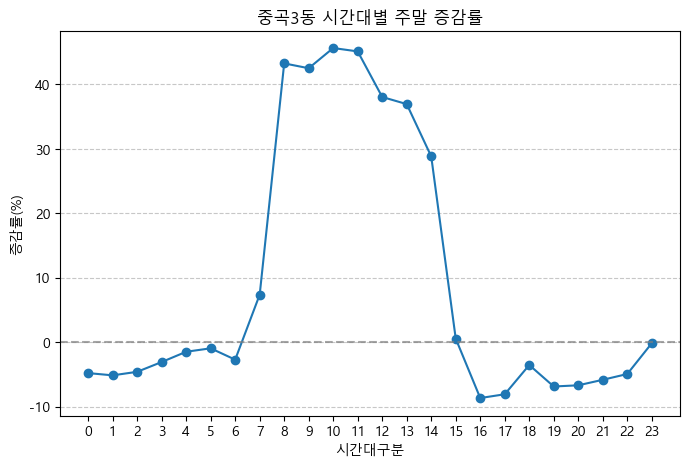

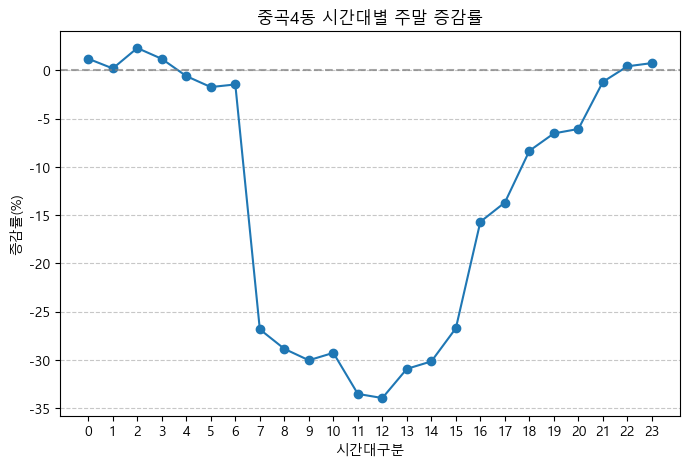

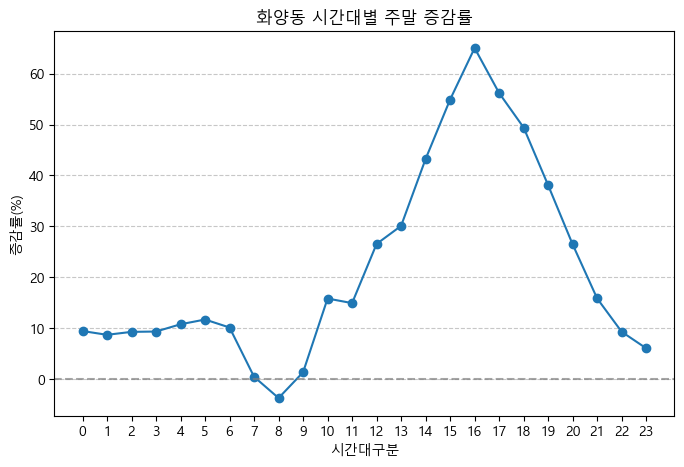

In [37]:
# 모든 행정동별 개별 그래프 생성
for dong in df_change['행정동'].unique():
    df_selected = df_change[df_change['행정동'] == dong]

    plt.figure(figsize=(8, 5))
    plt.plot(df_selected['시간대구분'], df_selected['증감률(%)'], marker='o', linestyle='-', label=dong)

    plt.xlabel('시간대구분')
    plt.ylabel('증감률(%)')
    plt.title(f'{dong} 시간대별 주말 증감률')
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)  # 기준선 추가
    plt.xticks(df_selected['시간대구분'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()


# 랭킹

In [74]:
# 평일 데이터만 필터링
df_weekday = data[data['평일/휴일'] == '평일'].copy()

# 시간대별 랭킹 계산
df_weekday['랭킹'] = df_weekday.groupby('시간대구분')['총0세부터9세생활인구수'].rank(ascending=False, method='min')

# 정렬 (시간대 → 랭킹 순)
df_weekday = df_weekday.sort_values(by=['시간대구분', '랭킹'])

# 결과 출력
print(df_weekday[['시간대구분', '행정동', '총0세부터9세생활인구수', '랭킹']])


     시간대구분   행정동  총0세부터9세생활인구수    랭킹
0        0   광장동   3729.464204   1.0
384      0  자양3동   2164.828252   2.0
144      0  구의3동   2012.476770   3.0
336      0  자양2동   1798.814204   4.0
96       0  구의2동   1487.544909   5.0
..     ...   ...           ...   ...
311     23  자양1동   1027.453313  11.0
503     23  중곡1동    998.985783  12.0
599     23  중곡3동    969.185974  13.0
263     23    능동    890.329539  14.0
695     23   화양동    653.692165  15.0

[360 rows x 4 columns]


In [54]:
df_weekday[['시간대구분', '행정동', '총0세부터9세생활인구수', '랭킹']]

,시간대구분,행정동,총0세부터9세생활인구수,랭킹
0,0,광장동,3729.464204,1.0
384,0,자양3동,2164.828252,2.0
144,0,구의3동,2012.476770,3.0
336,0,자양2동,1798.814204,4.0
96,0,구의2동,1487.544909,5.0
...,...,...,...,...
311,23,자양1동,1027.453313,11.0
503,23,중곡1동,998.985783,12.0
599,23,중곡3동,969.185974,13.0
263,23,능동,890.329539,14.0


In [66]:
test12 = df_weekday[df_weekday['시간대구분'] == 12]
test12 = test12[['시간대구분', '행정동', '총0세부터9세생활인구수', '랭킹']]
test12

,시간대구분,행정동,총0세부터9세생활인구수,랭킹
12,12,광장동,4377.389743,1.0
252,12,능동,2551.182887,2.0
396,12,자양3동,2490.356461,3.0
636,12,중곡4동,2359.017187,4.0
348,12,자양2동,1986.548052,5.0
156,12,구의3동,1739.630887,6.0
108,12,구의2동,1566.197470,7.0
60,12,구의1동,1247.809026,8.0
300,12,자양1동,1234.584704,9.0
204,12,군자동,1228.180222,10.0


In [75]:
test18 = df_weekday[df_weekday['시간대구분'] == 18]
test18 = test18[['시간대구분', '행정동', '총0세부터9세생활인구수', '랭킹']]
test18

,시간대구분,행정동,총0세부터9세생활인구수,랭킹
162,18,구의3동,3172.412165,1.0
18,18,광장동,3158.213057,2.0
402,18,자양3동,2249.206787,3.0
354,18,자양2동,1683.466452,4.0
642,18,중곡4동,1677.124061,5.0
258,18,능동,1496.067230,6.0
114,18,구의2동,1416.216613,7.0
306,18,자양1동,1296.623117,8.0
546,18,중곡2동,1202.186152,9.0
66,18,구의1동,1142.647639,10.0


In [76]:
# 두 개의 데이터프레임을 행정동 기준으로 병합
df_rank_compare = pd.merge(test18, test12, on='행정동', how='outer')
df_rank_compare

,시간대구분_x,행정동,총0세부터9세생활인구수_x,랭킹_x,시간대구분_y,총0세부터9세생활인구수_y,랭킹_y
0,18,광장동,3158.213057,2.0,12,4377.389743,1.0
1,18,구의1동,1142.647639,10.0,12,1247.809026,8.0
2,18,구의2동,1416.216613,7.0,12,1566.197470,7.0
3,18,구의3동,3172.412165,1.0,12,1739.630887,6.0
4,18,군자동,1044.281317,12.0,12,1228.180222,10.0
5,18,능동,1496.067230,6.0,12,2551.182887,2.0
6,18,자양1동,1296.623117,8.0,12,1234.584704,9.0
7,18,자양2동,1683.466452,4.0,12,1986.548052,5.0
8,18,자양3동,2249.206787,3.0,12,2490.356461,3.0
9,18,자양4동,1124.804826,11.0,12,1029.497583,12.0


# 활동시간 구분

In [69]:
# 평일 데이터만 필터링
df_weekday = data[data['평일/휴일'] == '평일'].copy()

# 활동/비활동 시간대 정의
inactive_hours = list(range(21, 25)) + list(range(0, 7))  # 21-24, 0-6
active_hours = list(range(7, 21))  # 7-20

# 비활동 시간 평균 계산
df_inactive = df_weekday[df_weekday['시간대구분'].isin(inactive_hours)].groupby('행정동')['총0세부터9세생활인구수'].mean().reset_index()
df_inactive.rename(columns={'총0세부터9세생활인구수': '비활동시간_평균'}, inplace=True)

# 활동 시간 평균 계산
df_active = df_weekday[df_weekday['시간대구분'].isin(active_hours)].groupby('행정동')['총0세부터9세생활인구수'].mean().reset_index()
df_active.rename(columns={'총0세부터9세생활인구수': '활동시간_평균'}, inplace=True)

# 두 개의 데이터프레임 병합
df_compare = pd.merge(df_inactive, df_active, on='행정동', how='outer')

# 활동/비활동 시간 비율 계산
df_compare['활동/비활동 비율'] = df_compare['활동시간_평균'] / df_compare['비활동시간_평균']

# 정렬 (활동시간 평균이 높은 순)
df_compare = df_compare.sort_values(by='활동시간_평균', ascending=False)

# 랭킹 추가
df_compare['비활동시간_랭킹'] = df_compare['비활동시간_평균'].rank(ascending=False, method='min')  # 높은 값일수록 높은 순위
df_compare['활동시간_랭킹'] = df_compare['활동시간_평균'].rank(ascending=False, method='min')
df_compare['비율_랭킹'] = df_compare['활동/비활동 비율'].rank(ascending=False, method='min')

# 결과 출력
df_compare


,행정동,비활동시간_평균,활동시간_평균,활동/비활동 비율,비활동시간_랭킹,활동시간_랭킹,비율_랭킹
0,광장동,3661.328765,3892.946977,1.063261,1.0,1.0,9.0
8,자양3동,2162.486615,2329.178790,1.077084,2.0,2.0,7.0
3,구의3동,2093.790232,2273.301316,1.085735,3.0,3.0,6.0
13,중곡4동,1494.393523,2055.451431,1.375442,5.0,4.0,3.0
5,능동,939.582790,1979.972757,2.107289,14.0,5.0,1.0
7,자양2동,1787.895782,1869.468942,1.045625,4.0,6.0,10.0
2,구의2동,1489.259670,1514.487992,1.016940,6.0,7.0,11.0
1,구의1동,1164.016011,1312.623526,1.127668,8.0,8.0,4.0
6,자양1동,1094.344838,1226.613850,1.120866,10.0,9.0,5.0
4,군자동,1053.338031,1121.755176,1.064953,11.0,10.0,8.0
